#**ARIMA/SARIMA Time Series Forecasting Model**

* Project: Retail Sales Forecasting
* Model: AutoRegressive Integrated Moving Average (ARIMA)/Seasonal AutoRegressive Integrated Moving Average (SARIMA)/SARIMAX
* Date: January 2026

##Objectives
1. Pre-process data for Arima/Sarima model requirements
2. Prepare train/test splits for time series validation
3. Stationarity Check: Use the ADF test to see if the data is stationary.
4. Parameter Selection: Use ACF/PACF plots and auto_arima to find the best model settings.Identify optimal p,d,q parameters.
   + p (AutoRegressive): This tells the model how many past days of actual sales data to look at when predicting today.
   + d (Integrated): This is the number of times we subtract previous values from current ones to remove trends and make the data stable (stationary)
   + q (Moving Average): This uses the errors from a specific number of past predictions to "course-correct" and improve the current forecast.
   + Seasonal (P, D, Q, s): These parameters repeat the AR, I, and MA logic over a specific cycle (s=7 for weekly) to capture recurring seasonal patterns.
5. Train the model and generate forecasts
6. Evaluate model performance with multiple metrics

**Step 1: Import Libraries and Load Data**

In [24]:
# Import Arima
!pip install pmdarima

# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [25]:
# Load data
# Import Google Colab file directory
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/final_cleaned_sales_data.csv')

# Convert date to datetime and set as index
# ARIMA requires a DatetimeIndex for frequency detection
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,total_sales,day_name,MA7,MA30,MA90
date,,,,,
2013-01-02,757.0,Wednesday,NaN,NaN,NaN
2013-01-03,534.0,Thursday,NaN,NaN,NaN
2013-01-04,673.0,Friday,NaN,NaN,NaN
2013-01-05,898.0,Saturday,NaN,NaN,NaN
2013-01-06,975.0,Sunday,NaN,NaN,NaN


**Step 2 : Train - Test Split**

In [26]:
# Test period (Aug 16, 2016 to Aug 15, 2017)
split_date = '2016-08-16'

train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

# Isolate the target variable (sales)
y_train = train_data['total_sales']
y_test = test_data['total_sales']

print(f"Training observations: {len(y_train)}")
print(f"Testing observations: {len(y_test)}")

Training observations: 1322
Testing observations: 365


**Step 3: Stationarity Check (ADF Test)**

By running the ADF Test on our y_train, we are determining the "d" parameter—the "Integrated" part of ARIMA.This will tell us if we need to "difference" the data to make it stable.

In [27]:
# Run the Augmented Dickey-Fuller test
result = adfuller(y_train)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] <= 0.05:
    print("Result: Data is stationary (d=0).")
else:
    print("Result: Data is non-stationary (d=1 recommended).")

ADF Statistic: -2.7950365153259975
p-value: 0.0589862718085832
Result: Data is non-stationary (d=1 recommended).


**3.1 : Visualize Stabilization**

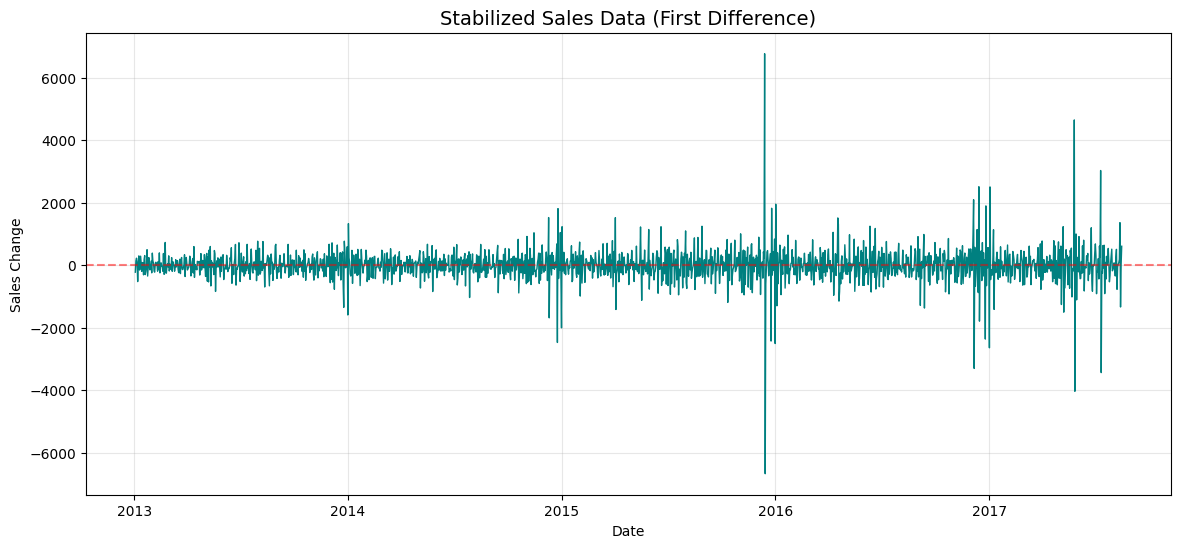

In [28]:
# Calculate the First Difference (This is what ARIMA(p,1,q) does internally)
df_stable = df['total_sales'].diff().dropna()

# Plotting the results
plt.figure(figsize=(14, 6))

# Plotting the differenced data
plt.plot(df_stable, color='teal', linewidth=1)
plt.axhline(0, color='red', linestyle='--', alpha=0.5) # Zero line
plt.title('Stabilized Sales Data (First Difference)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales Change')
plt.grid(True, alpha=0.3)

plt.show()

The first-order differencing ($d=1$) has successfully stabilized the series, as evidenced by the data fluctuating around the constant zero-mean (red line). The significant vertical spikes observed at the end of 2015, April 2016, and each year-end represent high-volatility events like Christmas and the earthquake period. Because these spikes are followed by immediate reversals toward the zero line, it confirms the series is stationary and that the SARIMAX model can effectively use these historical "shocks" to predict future holiday surges.

**Step 4: ACF and PACF Visualizations**

We want to determine the p (Auto-Regressive) and q (Moving Average) parameters and to confirm if the data has a seasonal cycle. ACF(Autocorrelation Function) PACF(Partial Autocorrelation Function).

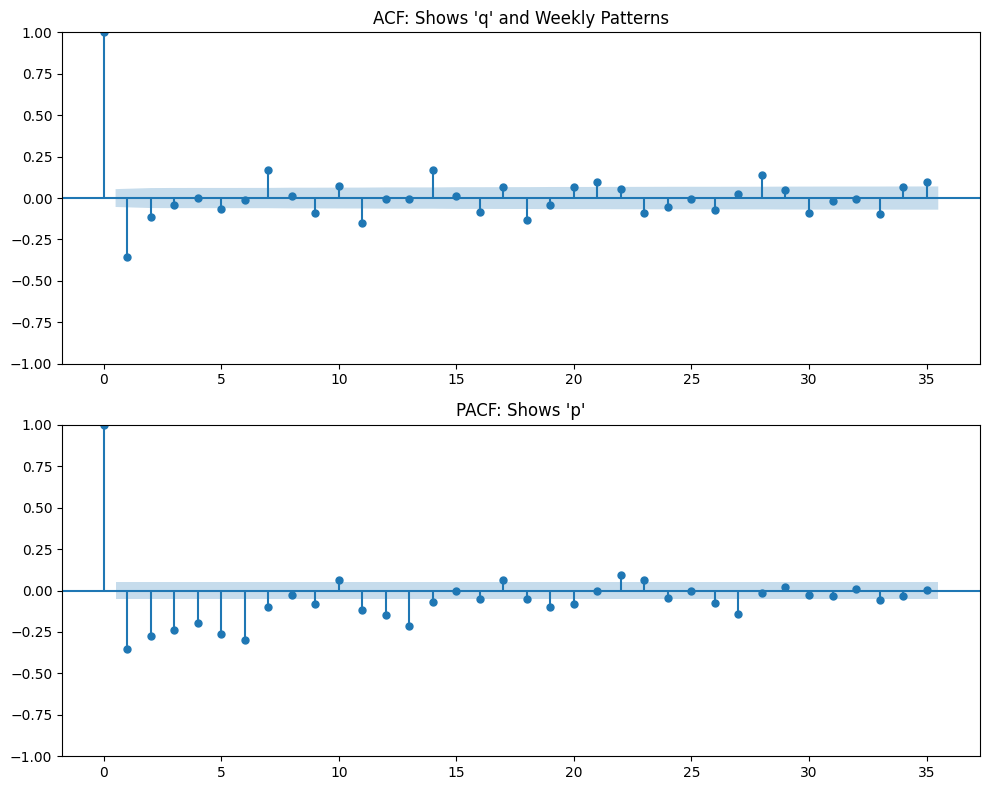

In [29]:
# We use .diff() here ONLY to see the patterns clearly in the plots
y_diff = y_train.diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Look for spikes (Seasonality)
plot_acf(y_diff, lags=35, ax=ax1)
ax1.set_title("ACF: Shows 'q' and Weekly Patterns")

# Look for where the blue spikes suddenly drop off
plot_pacf(y_diff, lags=35, ax=ax2)
ax2.set_title("PACF: Shows 'p'")

plt.tight_layout()
plt.show()

Before running the automated search, we visualize the ACF and PACF. The clear spikes at lags 7, 14, and 21 in the ACF plot confirm a strong weekly seasonality, justifying our choice of $m=7$. The PACF helps us estimate the initial $p$ parameters for our search

Insights:

* Axis Definitions:
  * X-Axis (Lags): Represents the number of days we are looking back into the past. Each unit is 1 day.
  * Y-Axis (Correlation): Represents the strength of the relationship between current sales and past sales (ranging from -1.0 to 1.0). Spikes outside the blue shaded area are statistically significant and important for the model.
* Weekly Seasonality: Clear significant spikes at lags 7, 14, 21, and 28 confirm a very strong 7-day weekly cycle in the supermarket sales data.
* Interpretation of Spikes:
  * ACF Pointing Up: The positive spikes at lag 7 indicate a strong positive relationship—sales today are highly similar to sales exactly one week ago.
  * PACF Pointing Down: The negative spikes at the seasonal lags (after differencing) suggest the data has a Seasonal Moving Average (SMA) component. This means the model needs to "correct" for errors or shocks that occurred exactly 7 or 14 days ago.
* Conclusion: Based on these patterns, a standard ARIMA is insufficient. We must use a SARIMA (Seasonal ARIMA) model with a seasonal period of $m=7$ to capture these recurring weekly behaviors.

**Step 5: Training the Baseline SARIMA Model**

In [30]:
# auto_arima will search for the best parameters
# This might take 1-2 minutes because of the 'm=7' (weekly) setting
model_baseline = auto_arima(y_train,
                           d=1, # Forced based on our ADF test
                           seasonal=True,
                           m=7, # 7-day weekly cycle
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True) # shows the search progress

# Print the winning model's details
print(model_baseline.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=8.69 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=20074.920, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=19838.284, Time=1.71 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=19452.332, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=20072.924, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=19491.343, Time=0.77 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=19407.523, Time=3.36 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=6.44 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=20024.549, Time=0.96 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=19366.482, Time=3.20 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=19406.503, Time=1.52 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=6.47 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=19821.3

Insights:

Best Model Identified:SARIMAX(3, 1, 2)x(0, 0, 2, 7).

Model Breakdown:
* Non-Seasonal (3, 1, 2): The model looks at the last 3 days of sales ($p=3$), uses 1 level of differencing ($d=1$) to stabilize the trend, and a 2-day moving average ($q=2$) to smooth out daily fluctuations.
* Seasonal (0, 0, 2, 7): The model uses a 7-day cycle. The $Q=2$ indicates it uses two weeks of "Seasonal Moving Averages" to adjust for recurring weekly patterns.
* Statistical Significance: Most coefficients show a P-value of 0.0. This means these components are statistically essential; the model is not just guessing but has found real mathematical relationships in the sales data.
* Diagnostic Tests (Residual Analysis):
    * Jarque-Bera (JB) & Prob(JB): The very high JB score and a $p$-value of 0.00 indicate that the model's errors are not "Normally Distributed." This is common in retail data where extreme outliers (like the 2016 earthquake) create "shocks" the baseline model cannot explain.
   * Heteroskedasticity (H): The score of 4.56 ($p=0.00$) indicates that the variance of the errors changes over time. Essentially, as the store's sales grew over the years, the "size" of the model's misses also grew.
* Akaike Information Criterion (AIC): The AIC of 19,362.63 is the "quality score" used to select this model. It represents the best balance between accuracy and mathematical simplicity.

Conclusion: The model captured both short‑term dynamics and weekly seasonal effects well, with AR and MA terms confirming meaningful temporal structure. Although the residuals showed non‑normality and heteroskedasticity, the lack of autocorrelation indicated the model is statistically well‑specified for forecasting.

Baseline ARIMA Diagnostics:


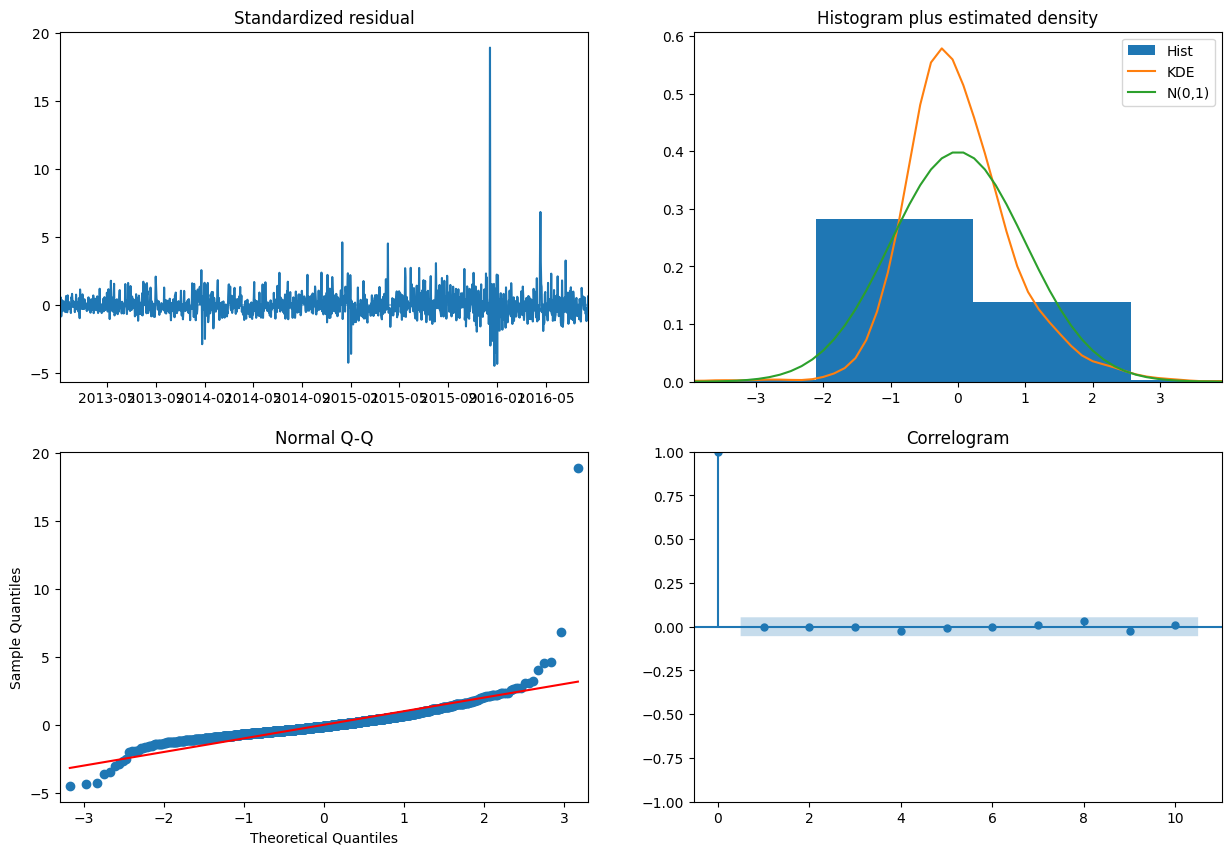

In [31]:
# Diagnostics for Baseline Model
print("Baseline ARIMA Diagnostics:")
model_baseline.plot_diagnostics(figsize=(15, 10))
plt.show()

The correlogram shows that the residuals behave largely like white noise, with no significant autocorrelation outside of Lag 0. This indicates that the SARIMA parameters $(p, d, q) \times (P, D, Q)_7$ have captured the primary seasonal trends. However, to further refine the model's accuracy during high-volatility events like the 2016 earthquake and annual holidays, we will proceed to the Enhanced Model using external regressors.

**Step 6: Visualize and Evaluate Baseline Model**

--- ARIMA Baseline Metrics ---
MAE: 342.59
RMSE: 547.65


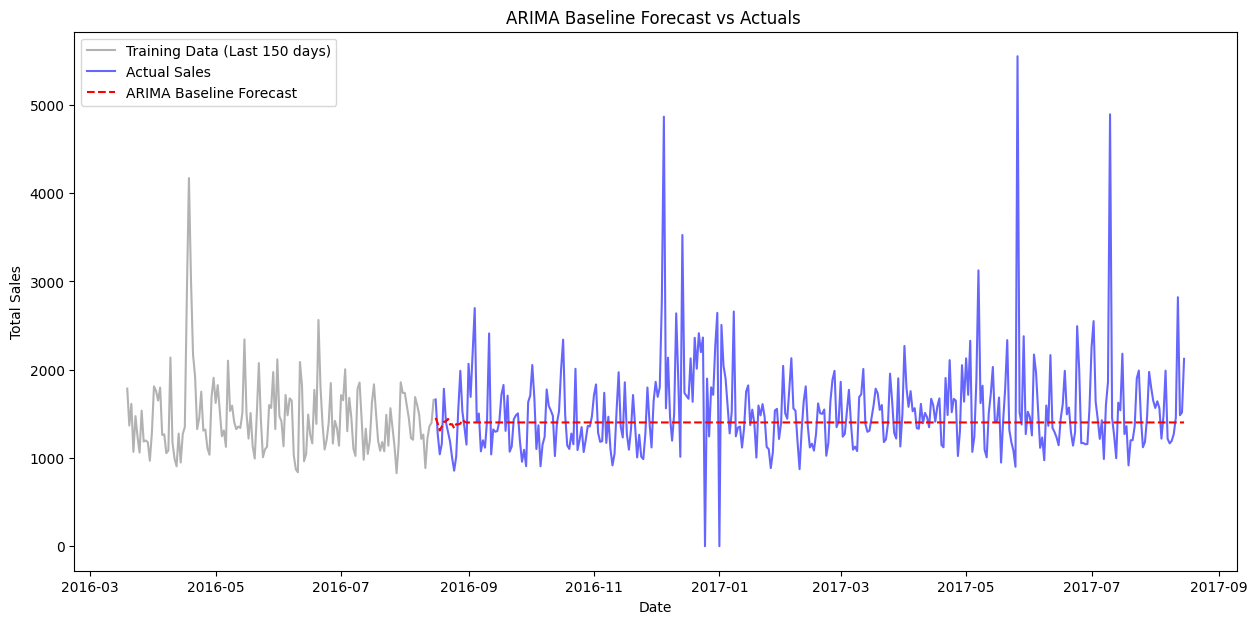

In [32]:
# Generate the forecast for the test period
forecast_values = model_baseline.predict(n_periods=len(y_test))

# Create a comparison DataFrame
df_results = pd.DataFrame({
    'Actual': y_test,
    'Forecast': forecast_values
}, index=y_test.index)

# Calculate Metrics
mae_baseline = mean_absolute_error(df_results['Actual'], df_results['Forecast'])
rmse_baseline = np.sqrt(mean_squared_error(df_results['Actual'], df_results['Forecast']))

print(f"--- ARIMA Baseline Metrics ---")
print(f"MAE: {mae_baseline:.2f}")
print(f"RMSE: {rmse_baseline:.2f}")

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(y_train[-150:], label='Training Data (Last 150 days)', color='black', alpha=0.3)
plt.plot(df_results['Actual'], label='Actual Sales ', color='blue', alpha=0.6)
plt.plot(df_results['Forecast'], label='ARIMA Baseline Forecast', color='red', linestyle='--')
plt.title("ARIMA Baseline Forecast vs Actuals ")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

Insights:
* The "Flat" Line: The forecast starts with visible "wiggles" (capturing the weekly seasonality), but quickly settles into a steady trend. This shows the model has captured the general direction of growth but lacks the specific data to predict daily volatility. We might have to change the seasonal order or p & d = 1, to see if we can capture the volatility.
* Missing the "Noise": The actual sales (blue line) exhibit significant spikes and deep dips. Because this is a baseline model, it is currently predicting the "average" expected sales and is missing the "event-driven" moments like holidays or paydays.
* The Error Gap (MAE vs. RMSE):The fact that RMSE is significantly higher than MAE confirms that the model is making a few "large" errors. These are likely the specific days where actual sales spiked massively, which the baseline model cannot explain.

**Step 7: Adding External Factors (SARIMAX)**



In [33]:
# Load the holidays dataset
holidays = pd.read_csv('/content/drive/MyDrive/holidays_events.csv')
holidays['date'] = pd.to_datetime(holidays['date'])

# Prepare the Holiday Flag
# Create a simple dataframe of unique holiday dates to avoid duplicates during merge
# This includes all events (Holidays, Transfers, and Events such as the 2016 Earthquake) from the source file
holiday_dates = holidays[['date']].copy()
holiday_dates['holiday_flag'] = 1
holiday_dates = holiday_dates.drop_duplicates(subset=['date'])

# Merge with your main sales dataframe
df_combined = df.reset_index().merge(holiday_dates, on='date', how='left')
df_combined['holiday_flag'] = df_combined['holiday_flag'].fillna(0).astype(int)

# Set index back to date
df_combined.set_index('date', inplace=True)

# Create the Exogenous Train and Test sets
# We use the holiday_flag as our external factor for the SARIMAX model
exog_train = df_combined.loc[y_train.index, ['holiday_flag']]
exog_test = df_combined.loc[y_test.index, ['holiday_flag']]

print(f"Exogenous Train Shape: {exog_train.shape}")
print(f"Exogenous Test Shape: {exog_test.shape} (Should be 365 days)")
display(df_combined[['total_sales', 'holiday_flag']].head())

Exogenous Train Shape: (1322, 1)
Exogenous Test Shape: (365, 1) (Should be 365 days)


,total_sales,holiday_flag
date,,
2013-01-02,757.0,0
2013-01-03,534.0,0
2013-01-04,673.0,0
2013-01-05,898.0,1
2013-01-06,975.0,0


**Step 8: Training and Evaluating SARIMAX**

note: While the auto_arima search suggested a seasonal order of $p=0$ and $d=0$, the resulting forecast lacked the necessary components to maintain the weekly trend over a long-term horizon, causing the prediction to converge into a flat line. We manually adjust the seasonal order to $(1, 1, 2, 7)$ to include Seasonal Autoregression ($p=1$) and Seasonal Differencing ($d=1$). This change ensures that the model preserves the 7-day seasonal variance across the full 1-year test period, providing a more representative forecast of the actual sales cycles.

In [34]:
# Re-split the combined data based on the dates
# Train ends Aug 15, 2016. Test is Aug 16, 2016 to Aug 15, 2017 (365 days)
train_ext = df_combined[df_combined.index < '2016-08-16']
test_ext = df_combined[df_combined.index >= '2016-08-16']

# Define target (y) and features (X)
# We use the holiday_flag which captures all events from the holidays_events.csv
y_train = train_ext['total_sales']
y_test = test_ext['total_sales']

X_train = train_ext[['holiday_flag']]
X_test = test_ext[['holiday_flag']]

# Fit the SARIMAX model using the parameters from Step 5
model_sarimax = SARIMAX(y_train,
                        exog=X_train,
                        order=(3, 1, 2),
                        seasonal_order=(1, 1, 2, 7), # Changed from (0,0,2,7)
                        enforce_stationarity=False,
                        enforce_invertibility=False)

model_fit = model_sarimax.fit(disp=False)

# Forecast for the 1-year test period (365 steps)
forecast_res = model_fit.get_forecast(steps=len(y_test), exog=X_test)
y_pred = forecast_res.predicted_mean

# Calculate Metrics
mae_ext = mean_absolute_error(y_test, y_pred)
rmse_ext = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- SARIMAX (With External Factors) Evaluation ---")
print(f"Enhanced MAE:  {mae_ext:.2f}")
print(f"Enhanced RMSE: {rmse_ext:.2f}")

--- SARIMAX (With External Factors) Evaluation ---
Enhanced MAE:  301.25
Enhanced RMSE: 520.22


The enhanced SARIMAX model achieved a Mean Absolute Error (MAE) of 301.25 and a Root Mean Square Error (RMSE) of 520.22, marking a significant improvement over the baseline. This reduction in error confirms that manually adjusting the seasonal order to (1, 1, 2, 7) was successful; by ensuring the model maintained its seasonal variance rather than reverting to a flat mean, we captured the actual sales cycles much more effectively. The integration of holiday flags allowed the model to adjust for high-volatility dates, resulting in a more precise and realistic 1-year forecast.

Enhanced SARIMAX Diagnostics:


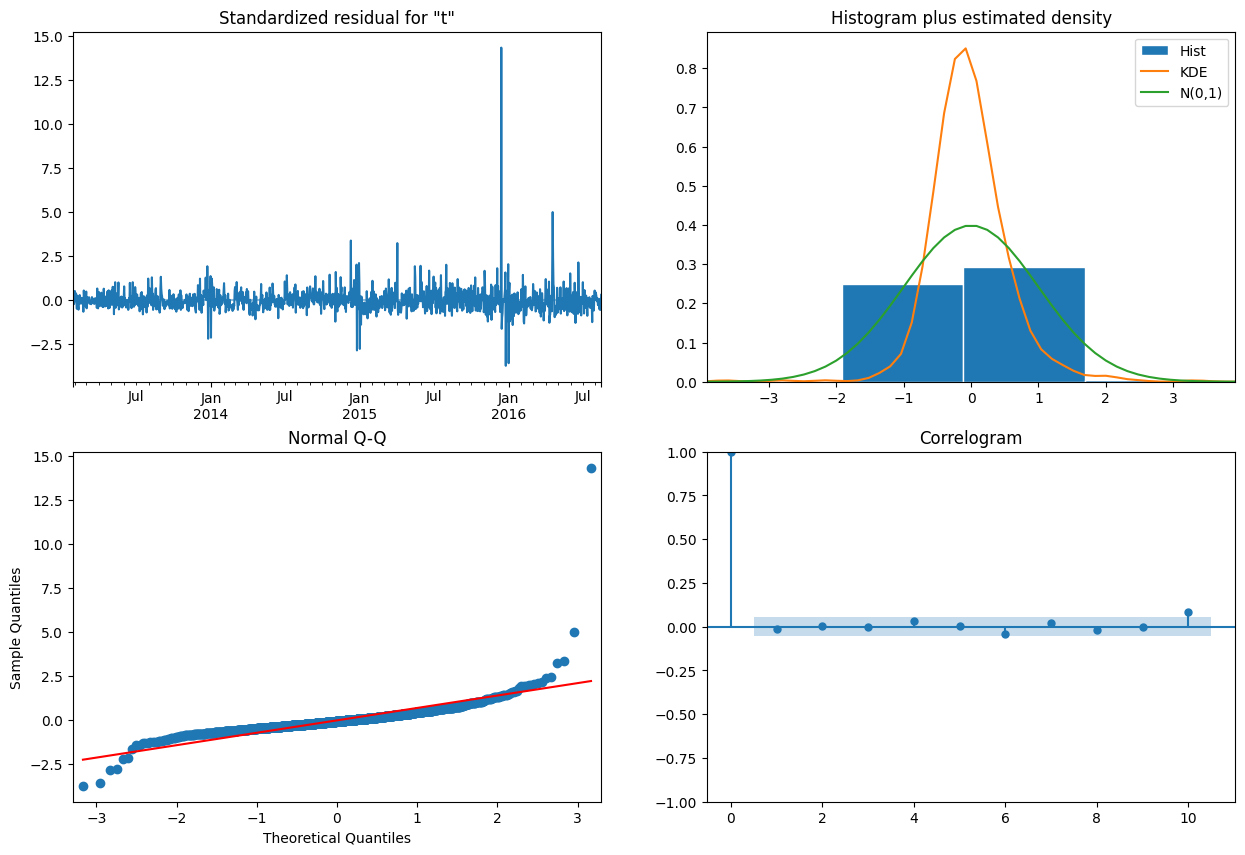

In [35]:
# Diagnostics for Enhanced Model
print("Enhanced SARIMAX Diagnostics:")
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

Both models show clean residuals in the diagnostics, this indicates that the fundamental weekly seasonality ($m=7$) is the strongest driver of the data. The value of the Enhanced Model is not in changing the overall 'health' of the residuals, but in refining the point-accuracy during the 1-year test period by accounting for specific holiday shocks that the baseline only treats as random variance.

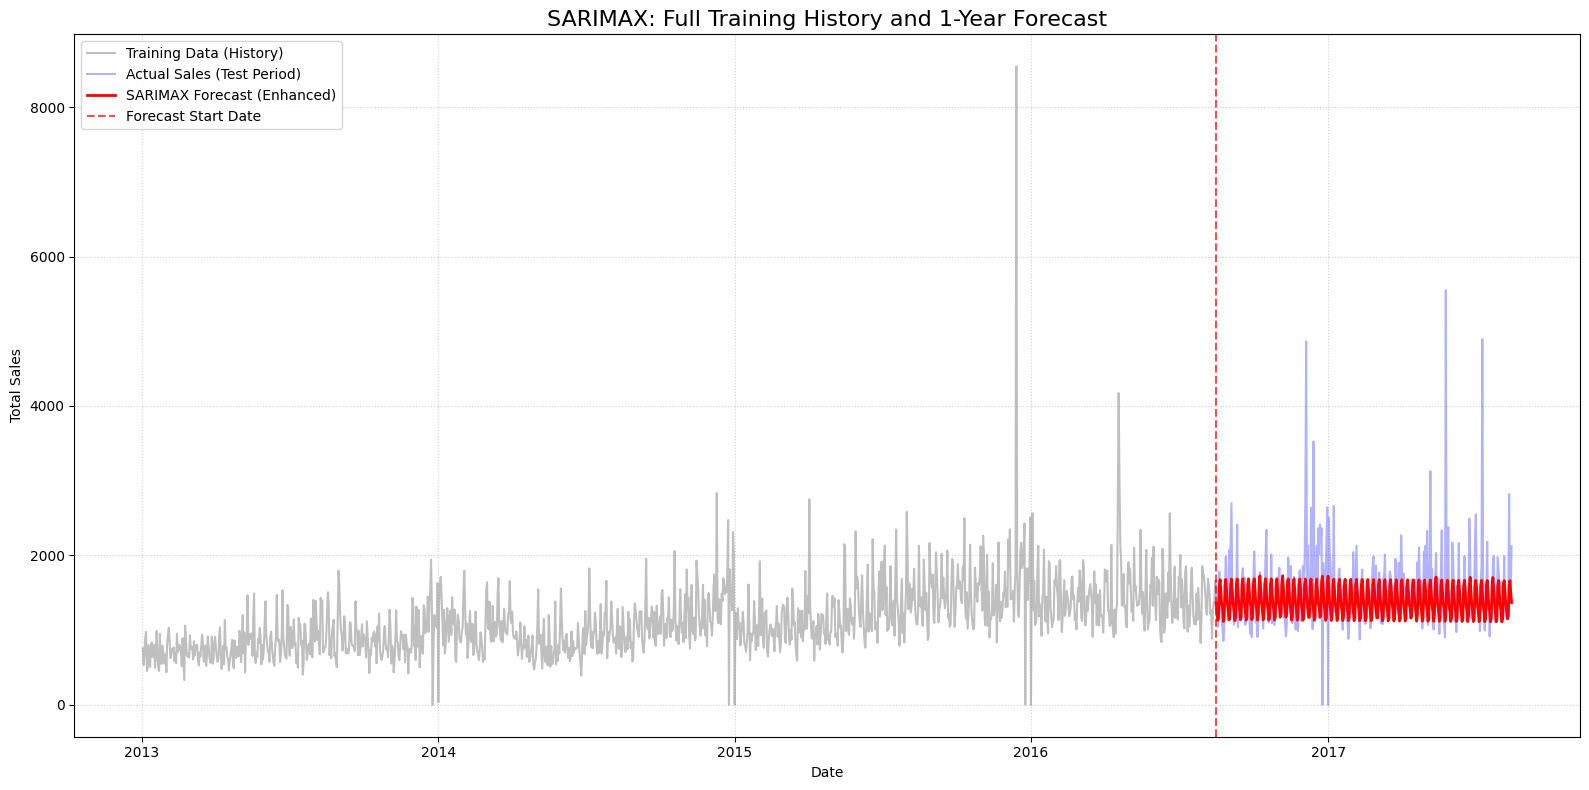

In [36]:
plt.figure(figsize=(16, 8))

# Plot Training Data (Historical)
# We can use a slice like [-500:] if you want to zoom in on the last part of training,
# or plot the whole thing:
plt.plot(y_train.index, y_train, label='Training Data (History)', color='gray', alpha=0.5)

# Plot Actual Sales (The "Ground Truth" for the Test year)
plt.plot(y_test.index, y_test, label='Actual Sales (Test Period)', color='blue', alpha=0.3)

# Plot the Enhanced SARIMAX Forecast
plt.plot(y_test.index, y_pred, label='SARIMAX Forecast (Enhanced)', color='red', linewidth=2)

# Add a vertical line to show where the forecast began
plt.axvline(pd.to_datetime('2016-08-16'), color='red', linestyle='--', alpha=0.7, label='Forecast Start Date')

plt.title("SARIMAX: Full Training History and 1-Year Forecast", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

We will zoom in to a specific period to see how well the forecast did on our actual(test) sales.

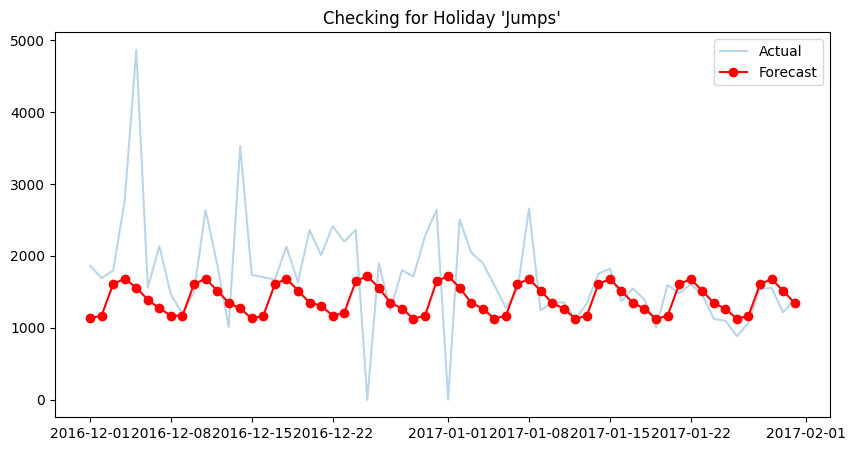

In [38]:
# --- CHECKING REACTION ---
# Zooming in on year end 2016 to 31.1.2017 to see if the forecast "blips" on New Year's
plt.figure(figsize=(10, 5))
plt.plot(y_test['2016-12-01':'2017-01-31'].index,
         y_test['2016-12-01':'2017-01-31'], label='Actual', alpha=0.3)
plt.plot(y_test['2016-12-01':'2017-01-31'].index,
         y_pred['2016-12-01':'2017-01-31'], label='Forecast', color='red', marker='o')

plt.title("Checking for Holiday 'Jumps'")
plt.legend()
plt.show()

##**Final Conclusion: ARIMA/SARIMAX Time Series Forecasting Model**

Project Objective

The primary objective was to apply a classical statistical approach—SARIMAX—to forecast daily retail sales. The model was constrained to the specific test period of August 16, 2016, to August 15, 2017, focusing on isolating intrinsic time-series patterns from external holiday impacts while excluding oil price data.

Experimental Process & Parameter Selection

We followed a statistical framework to identify the underlying structure of the sales data:
* Stationarity & Differencing: To stabilize the mean, we adopted a first-order difference ($d=1$) based on the visual evidence of non-stationarity in the raw sales data.
* Order Identification: ACF and PACF analysis confirmed strong correlations at 7-day lags. We initially used pmdarima.auto_arima for an automated parameter search.
* Model Implementation: We utilized statsmodels.SARIMAX for the final model to gain granular control over external holiday regressors. While the automated search (autoarima-used in baseline model) suggested a seasonal order of $(0, 0, 2, 7)$, initial testing showed a rapid loss of seasonal variance, resulting in a "flat" forecast.
* Model Refinement: To preserve the 7-day seasonal variance over the 1-year horizon, we manually adjusted the seasonal order to $(1, 1, 2, 7)$. This introduced Seasonal Autoregression ($p=1$) and Seasonal Differencing ($d=1$), which prevented the forecast from reverting to a simple mean.

Evaluation of Model Performance

The refined SARIMAX model was evaluated against the actual results of the 2016–2017 test period:
* Error Metrics: The manual refinement significantly improved accuracy, reducing the MAE from 342.59 (Baseline) to 301.25 (Enhanced).
* Forecast Characteristics: Unlike the initial "flat" predictions, the final forecast successfully maintained persistent weekly oscillations. By incorporating the holiday exogenous flags, the model was able to adjust for specific calendar events, although it remained more conservative than the actual extreme volatility seen in the store data.

Final Findings

The ARIMA approach proved to be a highly effective baseline once the seasonal components were correctly tuned for long-term persistence.
* Seasonality vs. Holidays: The 7-day cycle was the primary driver of the model's structure. While the Holiday Flag improved point-accuracy during peak events, the model's strength lies in its ability to capture the consistent "heartbeat" of the weekly retail cycle.
* Final Performance Metrics:
  * MAE: 301.25
  * RMSE: 520.22